# Homework 4
- Student: Aleksandra Kocot
 - [Git Hub page with the Homework Week4 questions](https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/cohorts/2023/04-evaluation/homework.md)

In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv

--2023-09-23 16:48:28--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8002::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73250 (72K) [text/plain]
Saving to: ‘AER_credit_card_data.csv’

AER_credit_card_dat 100%[===================>]  71,53K  --.-KB/s    in 0,04s   

2023-09-23 16:48:29 (1,58 MB/s) - ‘AER_credit_card_data.csv’ saved [73250/73250]



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import mutual_info_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

## Preparation
Create the target variable by mapping yes to 1 and no to 0.<br>
Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1.

In [2]:
df = pd.read_csv("data.csv")

In [3]:
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [4]:
columns = [
    'Make',
    'Model',
    'Year',
    'Engine HP',
    'Engine Cylinders',
    'Transmission Type',
    'Vehicle Style',
    'highway MPG',
    'city mpg'
]

In [5]:
df = df[columns + ["MSRP"]]

In [6]:
df.columns = df.columns.str.replace(' ', '_').str.lower()

In [7]:
df = df.fillna(0)

#### Target variable

In [10]:
price_avg = df["msrp"].mean()
price_avg

40594.737032063116

In [11]:
df["above_average"] = (df["msrp"] > price_avg).astype(int)

#### Train, test, validation set split

In [13]:
df_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

del df_train["above_average"] 
del df_val["above_average"]
del df_test["above_average"] 

## Question 1: ROC AUC feature importance
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

For each numerical variable, use it as score and compute AUC with the above_average variable
Use the training dataset for that
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['engine_hp'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?
- <b>engine_hp</b>
- engine_cylinders
- highway_mpg
- city_mpg

In [14]:
df_train

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,msrp
0,Toyota,Highlander Hybrid,2016,280.0,6.0,AUTOMATIC,4dr SUV,28,27,50485
1,Chevrolet,Impala Limited,2014,300.0,6.0,AUTOMATIC,Sedan,30,18,26840
2,Buick,Regal,2016,259.0,4.0,AUTOMATIC,Sedan,27,19,36490
3,Volkswagen,CC,2015,280.0,6.0,AUTOMATED_MANUAL,Sedan,25,17,43575
4,Dodge,Grand Caravan,2016,283.0,6.0,AUTOMATIC,Passenger Minivan,25,17,22595
...,...,...,...,...,...,...,...,...,...,...
7143,Subaru,Impreza,2015,148.0,4.0,MANUAL,4dr Hatchback,33,24,20995
7144,Infiniti,QX50,2016,325.0,6.0,AUTOMATIC,4dr SUV,24,17,35850
7145,Honda,Fit,2017,130.0,4.0,AUTOMATIC,4dr Hatchback,37,32,20265
7146,Audi,200,1991,162.0,5.0,AUTOMATIC,Sedan,20,16,2000


In [11]:
np.correlate(y_train, df_train[c])[0]

81

In [15]:
aucs = {}
numeric_cols = [c for c in df_train.columns if c not in ["make","model","year","transmission_type","vehicle_style","msrp"]]
for c in numeric_cols:
    feature_auc = roc_auc_score(y_train, df_train[c])
    feature_corr = np.corrcoef(y_train, df_train[c])
    if feature_auc < 0.5:
            feature_auc = roc_auc_score(y_train, -df_train[c])
    aucs[c] = [feature_auc, abs(feature_corr[0][1])]
    

In [16]:
results = pd.DataFrame(aucs).T
results.columns = ["AUC","COR_abs"]

In [17]:
results.sort_values(by="AUC", ascending=False).style.background_gradient(axis=0)  

,AUC,COR_abs
engine_hp,0.917103,0.661713
engine_cylinders,0.766116,0.451418
city_mpg,0.673424,0.155487
highway_mpg,0.633059,0.132043


Correlation shows linear relation while AUC detect also non-linear one so it may be useful for non-linear models.
- But logistic regression is linear underneath, so here it may be misleading (?)

#### ROC AUC

In [18]:
roc_auc_score([0,0,0,0,1,1,1,1], [0,0,0,0,1,1,1,1])

1.0

In [19]:
roc_auc_score([0,0,0,0,1,1,1,1], [0,1,0,1,0,1,0,1])

0.5

In [20]:
roc_auc_score([0,0,0,0,1,1,1,1], [10,20,30,40,50,60,70,80])

1.0

In [21]:
roc_auc_score([0,0,0,0,1,1,1,1], [10,20,30,40,45,46,47,48])

1.0

#### Correlation

In [22]:
np.corrcoef([0,0,0,0,1,1,1,1], [10,20,30,40,50,60,70,80])[0][1]

0.8728715609439693

In [23]:
np.corrcoef([0,0,0,0,1,1,1,1], [10,20,30,40,45,46,47,48])[0][1]

0.804195017233548

## Question 2: Training the model
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)<br>
What's the AUC of this model on the validation dataset? (round to 3 digits)
- 0.678
- 0.779
- 0.878
- <b>0.979</b>

In [26]:
cols = ['make', 'model', 'year', 'engine_hp', 'engine_cylinders',
       'transmission_type', 'vehicle_style', 'highway_mpg', 'city_mpg']

In [31]:
train_dict = df_train[cols].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)
X_train = dv.transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dict = df_val[cols].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:,1]

accuracy = roc_auc_score(y_val, y_pred)
np.round(accuracy,3)

0.98

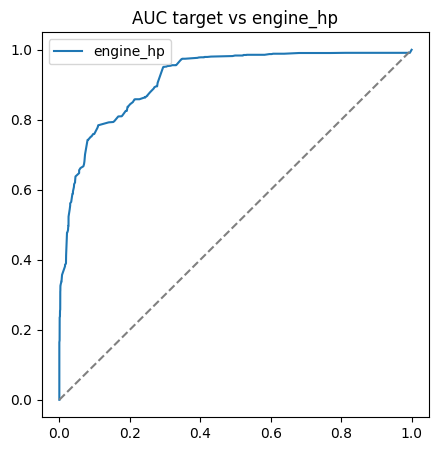

In [34]:
plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_train, df_train.engine_hp)
plt.plot(fpr, tpr, label='engine_hp')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.title("AUC target vs engine_hp")
plt.legend()
plt.show()

## Question 3: Precision and Recall
Now let's compute precision and recall for our model.<br>

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01<br>
For each threshold, compute precision and recall<r>
Plot them<br>
At which threshold precision and recall curves intersect?
- 0.28
- <b>0.48</b>
- 0.68
- 0.88


In [35]:
thrs = np.linspace(0,0.99,100)
thrs

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])

In [36]:
precision_recall = {}
for t in thrs:
    precision = precision_score(y_val, y_pred>t)
    recall = recall_score(y_val, y_pred>t)
    precision_recall[t] = [precision, recall]

In [37]:
df_p_r = pd.DataFrame(precision_recall).T
df_p_r.columns = ["precision", "recall"]

<Figure size 600x600 with 0 Axes>

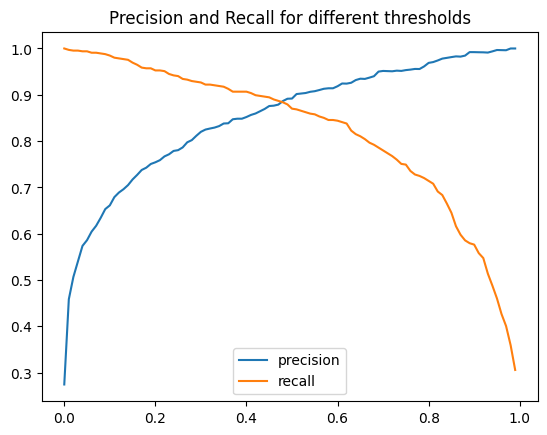

In [38]:
plt.figure(figsize=(6, 6));
df_p_r.plot();
plt.title("Precision and Recall for different thresholds");

In [40]:
df_p_r

,precision,recall
0.00,0.274444,1.000000
0.01,0.458509,0.996942
0.02,0.506615,0.995413
0.03,0.540249,0.995413
0.04,0.573698,0.993884
...,...,...
0.95,0.996689,0.460245
0.96,0.996429,0.426606
0.97,0.996198,0.400612
0.98,1.000000,0.359327


In [50]:
df_p_r.loc[abs(df_p_r.precision - df_p_r.recall) < 0.01]

,precision,recall
0.47,0.878788,0.886850
0.48,0.886503,0.883792


##### Answer: Precision and recall intersect for thresholds about 0.475

## Question 4: F1 score
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both<br>

This is the formula for computing <br>
F1 = 2 * P * R / ( P + R )
Where <br>
P is precision and<br> 
R is recall.<br>

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01<br>

At which threshold F1 is maximal?<br>
- 0.12
- 0.32
- <b>0.52</b>
- 0.72

In [51]:
df_p_r["f1_score"] = 2 * df_p_r.precision * df_p_r.recall * (df_p_r.precision + df_p_r.recall)

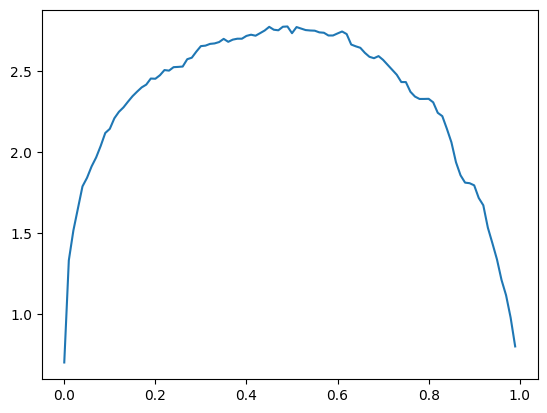

In [52]:
df_p_r.f1_score.plot();

In [54]:
df_p_r.sort_values(by=["f1_score"], ascending=False).head(10)

,precision,recall,f1_score
0.49,0.891473,0.879205,2.775670
0.48,0.886503,0.883792,2.773997
0.45,0.875749,0.894495,2.773452
0.51,0.901587,0.868502,2.772065
0.52,0.902711,0.865443,2.762726
0.46,0.876506,0.889908,2.755641
0.53,0.903846,0.862385,2.753426
0.47,0.878788,0.886850,2.752111
0.54,0.906452,0.859327,2.750866
0.44,0.869436,0.896024,2.750715


##### Answer: F1 score is the highest for threshold about 0.49

## Question 5: 5-Fold CV
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:<br>

KFold(n_splits=5, shuffle=True, random_state=1)<br>
Iterate over different folds of df_full_train<br>
Split the data into train and validation<br>
Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)<br>
Use AUC to evaluate the model on validation<br>
How large is standard devidation of the scores across different folds?
- <b>0.003</b>
- 0.030
- 0.090
- 0.140

In [61]:
def train(df_train, y_train, c=1.0):
    train_dict = df_train[cols].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    dv.fit(train_dict)
    X_train = dv.transform(train_dict)
    
    model = LogisticRegression(solver="liblinear", C=c, max_iter=1000)
    model.fit(X_train, y_train)
    return dv, model

def predict(df, dv, model):
    dicts = df[cols].to_dict(orient='records')
    X = dv.transform(dicts)
    return model.predict_proba(X)[:,1]

In [62]:
dv, model = train(df_train, y_train)
y_pred = predict(df_val, dv, model)

In [63]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full):
    df_train = df_full.iloc[train_idx]
    df_val = df_full.iloc[val_idx]
    
    y_train = df_train.above_average
    y_val = df_val.above_average
    
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
    
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print(f"{np.mean(scores):0.3f} +- {np.std(scores):0.3f}")

0.979 +- 0.002


## Question 6: Hyperparemeter Tuning
Now let's use 5-Fold cross-validation to find the best parameter C<br>

Iterate over the following C values: [0.01, 0.1, 0.5, 10]<br>
Initialize KFold with the same parameters as previously<br>
Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)<br>
Compute the mean score as well as the std (round the mean and std to 3 decimal digits)<br>
Which C leads to the best mean score?
- 0.01
- 0.1
- 0.5
- <b>10</b>
  
If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.

In [66]:
Cs = {}
n_splits=5
for c in [0.01, 0.1, 0.5, 10]:
    scores = []

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    
    for train_idx, val_idx in kfold.split(df_full):
        df_train = df_full.iloc[train_idx]
        df_val = df_full.iloc[val_idx]
        
        y_train = df_train.above_average
        y_val = df_val.above_average
        
        dv, model = train(df_train, y_train, c)
        y_pred = predict(df_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    
        Cs[c] = [np.mean(scores), np.std(scores)]

In [67]:
final_scores = pd.DataFrame(Cs).T
final_scores.columns = ["auc_avg", "auc_std"]

In [69]:
final_scores.sort_values(by="auc_avg", ascending=False).round(3)

,auc_avg,auc_std
10.00,0.981,0.003
0.50,0.977,0.002
0.10,0.972,0.002
0.01,0.952,0.003
